# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

3.7.4


# Przygotowanie odpowiednich danych

In [2]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../../data/Casia'
A_folder = 'originals'
B_folder = 'photoshops'

In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [4]:
# Wilkości

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,../../data/Casia/originals/Au_sec_30147.jpg,0
1,../../data/Casia/photoshops/Tp_S_NRN_S_B_sec20...,1
2,../../data/Casia/originals/Au_nat_30329.jpg,0
3,../../data/Casia/photoshops/Tp_D_NRN_S_N_sec00...,1
4,../../data/Casia/photoshops/Tp_S_CRN_M_N_nat10...,1


In [8]:
df.shape

(12614, 2)

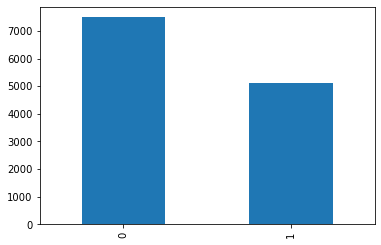

In [9]:
df['category'].value_counts().plot.bar()

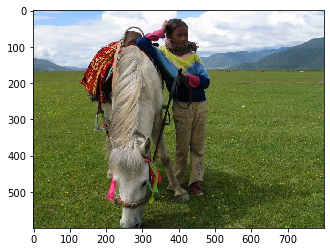

In [10]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka zdjęć

In [11]:
from skimage.feature import hog
from skimage.color import rgb2gray

In [12]:
import mahotas
import cv2
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

def ft_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hu_moments = cv2.HuMoments(cv2.moments(image))
    return scaler.fit_transform(hu_moments).flatten()

def ft_haralick(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(image).mean(axis=0)
    return scaler.fit_transform(haralick.reshape(-1, 1)).flatten()

def ft_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # chanels: [0,1,2], bo mamy przestrzeń HSV
    # mask: None
    # histSize: [8, 8, 8], bin count, po 8 dla każdego z kanałów
    # ranges : [0, 256, 0, 256, 0, 256], wszystko dla każdego z 3 kanałów
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist)
    hist = hist.flatten()
    return hist

def ft_hog(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(image, block_norm='L2-Hys', pixels_per_cell=(32, 32))
    return scaler.fit_transform(hog_features.reshape(-1, 1)).flatten()

def preprocess_image(image_path, hog=True):
    try:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        histogram = ft_histogram(image)
        haralick = ft_haralick(image)
        hu = ft_hu_moments(image)
        if hog == True:
            hog = ft_hog(image)
            global_feature = numpy.hstack([histogram, haralick, hu, hog])
        elif hog == False:
            global_feature = numpy.hstack([histogram, haralick, hu])
        return global_feature
    except Exception as e:
        print(f'Problem with {image_path}, error_msg: {str(e)}')
    

# Przeliczenie Cech Zdjęć + Kategorii

In [13]:
g_f = []
g_f_n_h = []
l = []

for i in df['filename']:
    data_img = preprocess_image(i)
    data_img_no_hog = preprocess_image(i, hog=False)
    g_f.append(data_img)
    g_f_n_h.append(data_img_no_hog)

for i in df['category']:
    if i == 0:
        l.append('original')
    else:
        l.append('photoshop')

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

print(f'Wektor zdjęć z HOG: {numpy.array(g_f).shape}')
print(f'Wektor zdjęć bez HOG: {numpy.array(g_f_n_h).shape}')
print(f'Wektor kategorii słownych: {numpy.array(l).shape}\n')

# Label Encoder
# Koty - 0
# Psy - 1
targetNames = numpy.unique(l)
print(targetNames)
le = LabelEncoder()
target = le.fit_transform(l)

print(f'Wektor kategorii liczbowych: {target.shape}')
print(f'Skalowany wektor zdjęć z HOG: {numpy.array(g_f).shape}')
print(f'Skalowany wektor zdjęć bez HOG: {numpy.array(g_f_n_h).shape}\n')

print(f'Max arg z skalowanego(z HOG): {numpy.argmax(g_f[0])}, Min arg z skalowanego(z HOG): {numpy.argmin(g_f[0])}')
print(f'Max z skalowanego(z HOG): {numpy.amax(g_f[0])}, Min z skalowanego(z HOG): {numpy.amin(g_f[0])}\n')

print(f'Max arg z skalowanego(bez HOG): {numpy.argmax(g_f_n_h[0])}, Min arg z skalowanego(bez HOG): {numpy.argmin(g_f_n_h[0])}')
print(f'Max z skalowanego(bez HOG): {numpy.amax(g_f_n_h[0])}, Min z skalowanego(bez HOG): {numpy.amin(g_f_n_h[0])}')

Wektor zdjęć z HOG: (12614, 856)
Wektor zdjęć bez HOG: (12614, 532)
Wektor kategorii słownych: (12614,)

['original' 'photoshop']
Wektor kategorii liczbowych: (12614,)
Skalowany wektor zdjęć z HOG: (12614, 856)
Skalowany wektor zdjęć bez HOG: (12614, 532)

Max arg z skalowanego(z HOG): 518, Min arg z skalowanego(z HOG): 0
Max z skalowanego(z HOG): 1.0, Min z skalowanego(z HOG): 0.0

Max arg z skalowanego(bez HOG): 518, Min arg z skalowanego(bez HOG): 0
Max z skalowanego(bez HOG): 1.0, Min z skalowanego(bez HOG): 0.0


# Zapis/Odczyt

In [15]:
import h5py

def save(features, labels, dataframe, name):
    h5f_data = h5py.File('data_' + str(name) + '.h5', 'w')
    h5f_data.create_dataset('dataset', data=numpy.array(features))

    h5f_label = h5py.File('labels_' + str(name) + '.h5', 'w')
    h5f_label.create_dataset('dataset', data=numpy.array(labels))

    h5f_data.close()
    h5f_label.close()

    dataframe.to_csv('dataframe_' + str(name) + '.csv')
    
def load(features, labels, dataframe):
    h5f_data  = h5py.File(features, 'r')
    h5f_label = h5py.File(labels, 'r')

    global_features_string = h5f_data['dataset']
    global_labels_string   = h5f_label['dataset']

    global_features = numpy.array(global_features_string)
    global_labels   = numpy.array(global_labels_string)

    h5f_data.close()
    h5f_label.close()
    
    df = pd.read_csv(dataframe, index_col = 0)  
    
    return global_features, global_labels, df
    
save(g_f, target, df, name='Casia_with_HOG')
save(g_f_n_h, target, df, name='Casia_without_HOG')

# B od BIG - więcej danych(z HOGiem), S - small(bez HOGa)
global_features_B, global_labels_B, df_B = load('data_Casia_with_HOG.h5', 'labels_Casia_with_HOG.h5', 'dataframe_Casia_with_HOG.csv')
global_features_S, global_labels_S, df_S = load('data_Casia_without_HOG.h5', 'labels_Casia_without_HOG.h5', 'dataframe_Casia_without_HOG.csv')

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=532)
global_features_B_PCA = pca.fit_transform(global_features_B)
global_features_S_PCA = pca.fit_transform(global_features_S)

save(global_features_B_PCA, target, df, name='Casia_with_HOG_with_PCA')
save(global_features_S_PCA, target, df, name='Casia_without_HOG_without_PCA')

# B od BIG - więcej danych(z HOGiem), S - small(bez HOGa)
global_features_B_PCA, global_labels_B_PCA, df_B_PCA = load('data_Casia_with_HOG_with_PCA.h5', 'labels_Casia_with_HOG_with_PCA.h5', 'dataframe_Casia_with_HOG_with_PCA.csv')
global_features_S_PCA, global_labels_S_PCA, df_S_PCA = load('data_Casia_without_HOG_without_PCA.h5', 'labels_Casia_without_HOG_without_PCA.h5', 'dataframe_Casia_without_HOG_without_PCA.csv')

In [17]:
print(f'Z HOG:')
print(f'\t Wektor zdjęć: {global_features_B.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_B.shape}\n')
print(f'\t Wektor dataframe: {df_B.shape}\n\n')


print(f'BEZ HOG:')
print(f'\t Wektor zdjęć: {global_features_S.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_S.shape}\n')
print(f'\t Wektor dataframe: {df_S.shape}\n')


print(f'Z HOG + PCA:')
print(f'\t Wektor zdjęć: {global_features_B_PCA.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_B_PCA.shape}\n')
print(f'\t Wektor dataframe: {df_B_PCA.shape}\n\n')


print(f'BEZ HOG + PCA:')
print(f'\t Wektor zdjęć: {global_features_S_PCA.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_S_PCA.shape}\n')
print(f'\t Wektor dataframe: {df_S_PCA.shape}\n')

Z HOG:
	 Wektor zdjęć: (12614, 856)
	 Wektor kategorii słownych: (12614,)

	 Wektor dataframe: (12614, 2)


BEZ HOG:
	 Wektor zdjęć: (12614, 532)
	 Wektor kategorii słownych: (12614,)

	 Wektor dataframe: (12614, 2)

Z HOG + PCA:
	 Wektor zdjęć: (12614, 532)
	 Wektor kategorii słownych: (12614,)

	 Wektor dataframe: (12614, 2)


BEZ HOG + PCA:
	 Wektor zdjęć: (12614, 532)
	 Wektor kategorii słownych: (12614,)

	 Wektor dataframe: (12614, 2)



In [18]:
df_B.head()

,filename,category
0,../../data/Casia/originals/Au_sec_30147.jpg,0
1,../../data/Casia/photoshops/Tp_S_NRN_S_B_sec20...,1
2,../../data/Casia/originals/Au_nat_30329.jpg,0
3,../../data/Casia/photoshops/Tp_D_NRN_S_N_sec00...,1
4,../../data/Casia/photoshops/Tp_S_CRN_M_N_nat10...,1


In [19]:
df_S.head()

,filename,category
0,../../data/Casia/originals/Au_sec_30147.jpg,0
1,../../data/Casia/photoshops/Tp_S_NRN_S_B_sec20...,1
2,../../data/Casia/originals/Au_nat_30329.jpg,0
3,../../data/Casia/photoshops/Tp_D_NRN_S_N_sec00...,1
4,../../data/Casia/photoshops/Tp_S_CRN_M_N_nat10...,1


# Funkcję liczące statystyki

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [21]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

# Funkcje do liczenia modelu

In [22]:
from sklearn.svm import SVC

def do_the_thing(features, labels):
    
    tcm_list = []
    tAccuracy_list = []
    tPrecision_list = []
    tRecall_list = []
    tFScore_list = []
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=odp)
    svm = SVC(kernel='rbf', probability=True, random_state=odp, verbose=True)
    
    for train_index, test_index in kf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        svm.fit(X_train, y_train)
        
        y_pred = svm.predict(X_test)
        accuracy, precision, recall, fscore = countStats(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        tAccuracy_list.append(accuracy)
        tPrecision_list.append(precision)
        tRecall_list.append(recall)
        tFScore_list.append(fscore)
        tcm_list.append(cm)

    
    print(f'Kształt danych:')
    print(f'\t X_train: {X_train.shape}')
    print(f'\t X_test: {X_test.shape}')
    print(f'\t y_train: {y_train.shape}')
    print(f'\t y_test: {y_test.shape}')
    
    accuracy_m = numpy.mean(tAccuracy_list)
    precision_m = numpy.mean(tPrecision_list)
    recall_m = numpy.mean(tRecall_list)
    fscore_m = numpy.mean(tFScore_list)
    
    accuracy_std = numpy.std(tAccuracy_list)
    precision_std = numpy.std(tPrecision_list)
    recall_std = numpy.std(tRecall_list)
    fscore_std = numpy.std(tFScore_list)
    
    print(f'\nAccuracy: {accuracy_m:.3f} ({accuracy_std:.2f})\n' +
          f'Precision: {precision_m:.3f} ({precision_std:.2f})\n' +
          f'Recall: {recall_m:.3f} ({recall_std:.2f})\n' +
          f'F-score: {fscore_m:.3f} ({fscore_std:.2f})\n')
    
    cm = sum(tcm_list)
    
    plot_cm(cm, ['Originals', 'Photoshops'])
    
    print(f'\n{cm}\n')


# HOG

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Kształt danych:
	 X_train: (10092, 856)
	 X_test: (2522, 856)
	 y_train: (10092,)
	 y_test: (2522,)

Accuracy: 0.654 (0.01)
Precision: 0.647 (0.01)
Recall: 0.654 (0.01)
F-score: 0.634 (0.01)


[[6257 1234]
 [3128 1995]]



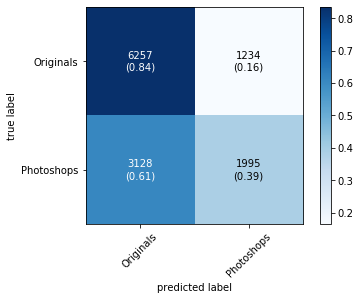

In [23]:
do_the_thing(global_features_B, global_labels_B)

# Bez HOG

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Kształt danych:
	 X_train: (10092, 532)
	 X_test: (2522, 532)
	 y_train: (10092,)
	 y_test: (2522,)

Accuracy: 0.658 (0.01)
Precision: 0.653 (0.01)
Recall: 0.658 (0.01)
F-score: 0.632 (0.01)


[[6440 1051]
 [3266 1857]]



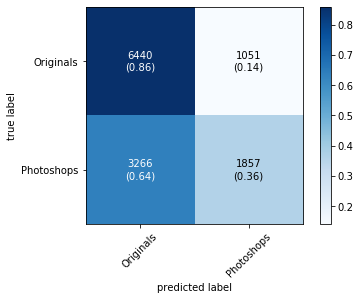

In [24]:
do_the_thing(global_features_S, global_labels_S)

# HOG -> PCA

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Kształt danych:
	 X_train: (10092, 532)
	 X_test: (2522, 532)
	 y_train: (10092,)
	 y_test: (2522,)

Accuracy: 0.663 (0.01)
Precision: 0.657 (0.01)
Recall: 0.663 (0.01)
F-score: 0.657 (0.01)


[[5785 1706]
 [2541 2582]]



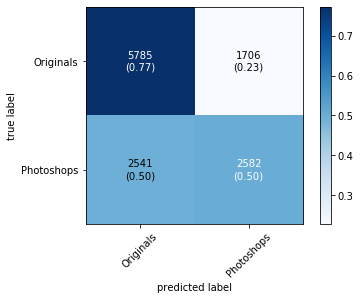

In [25]:
do_the_thing(global_features_B_PCA, global_labels_B_PCA)

# Bez HOG -> PCA

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Kształt danych:
	 X_train: (10092, 532)
	 X_test: (2522, 532)
	 y_train: (10092,)
	 y_test: (2522,)

Accuracy: 0.679 (0.01)
Precision: 0.674 (0.01)
Recall: 0.679 (0.01)
F-score: 0.674 (0.01)


[[5826 1665]
 [2384 2739]]



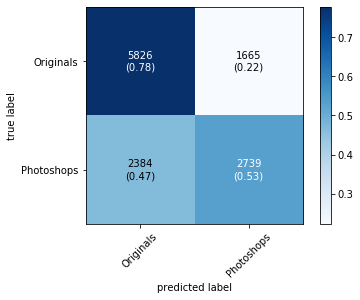

In [26]:
do_the_thing(global_features_S_PCA, global_labels_S_PCA)